<a href="https://colab.research.google.com/github/Ahmed-Camara/Face-Mask-Detection/blob/main/face_mask_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import zipfile
path = '/content/drive/MyDrive/ML_DL_practice/Face_Mask_Detection/data/archive.zip'
with zipfile.ZipFile(path,'r') as zp:
  zp.extractall('/content/dataset/')

In [4]:
train_path = '/content/dataset/New Masks Dataset/Train'
test_path = '/content/dataset/New Masks Dataset/Test'
val_path = '/content/dataset/New Masks Dataset/Validation'

In [5]:
os.listdir(train_path)

['Mask', 'Non Mask']

In [6]:
input = (224,224)

In [7]:
train_dataset = image_dataset_from_directory(train_path,image_size=input,shuffle=True,seed=42)
val_dataset = image_dataset_from_directory(val_path,image_size=input,shuffle=True,seed=42)
test_dataset = image_dataset_from_directory(test_path,image_size=input,shuffle=True,seed=42)

Found 600 files belonging to 2 classes.
Found 306 files belonging to 2 classes.
Found 100 files belonging to 2 classes.


In [8]:
class_names = train_dataset.class_names
class_names

['Mask', 'Non Mask']

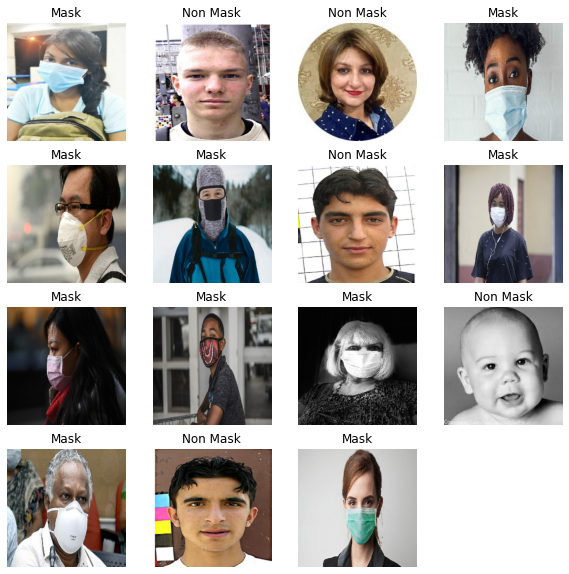

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(15):
        ax = plt.subplot(4,4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [10]:
IMAGE_SHAPE = input + (3,)

In [11]:
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

def data_augmenter():
  data_augmentation = tf.keras.Sequential()
  data_augmentation.add(RandomFlip('horizontal'))
  data_augmentation.add(RandomRotation(0.2))
  return data_augmentation

In [12]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0,
                                              patience=8,restore_best_weights=True)

callbacks = [stop_early]

In [13]:
BATCH_SIZE = 64
loss_function = tf.keras.losses.BinaryCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
metrics = ['accuracy']
drop = 0.25

In [14]:
preprocess_input = tf.keras.applications.efficientnet.preprocess_input
base_model = tf.keras.applications.EfficientNetB1(input_shape=IMAGE_SHAPE,include_top=False,weights='imagenet')

27033600/27018416 [==============================] - 0s 0us/step


In [15]:
data_augmentation = data_augmenter()

inputs = tf.keras.Input(shape=IMAGE_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(drop)(x)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)

In [16]:
base_model.trainable = True

fine_tune_at = 200


for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
    
 
model.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

history = model.fit(train_dataset,
                         epochs=50,batch_size=BATCH_SIZE,
                         validation_data=val_dataset,callbacks=callbacks)

Epoch 1/50
19/19 [==============================] - 43s 816ms/step - loss: 0.2930 - accuracy: 0.8667 - val_loss: 0.0488 - val_accuracy: 0.9869
Epoch 2/50
19/19 [==============================] - 11s 547ms/step - loss: 0.0313 - accuracy: 0.9850 - val_loss: 0.1007 - val_accuracy: 0.9673
Epoch 3/50
19/19 [==============================] - 14s 693ms/step - loss: 0.0167 - accuracy: 0.9917 - val_loss: 0.0381 - val_accuracy: 0.9869
Epoch 4/50
19/19 [==============================] - 11s 554ms/step - loss: 0.0053 - accuracy: 0.9967 - val_loss: 0.0353 - val_accuracy: 0.9869
Epoch 5/50
19/19 [==============================] - 11s 550ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0392 - val_accuracy: 0.9902
Epoch 6/50
19/19 [==============================] - 12s 566ms/step - loss: 4.1568e-04 - accuracy: 1.0000 - val_loss: 0.0410 - val_accuracy: 0.9902
Epoch 7/50
19/19 [==============================] - 11s 546ms/step - loss: 0.0029 - accuracy: 0.9983 - val_loss: 0.0679 - val_accuracy: 0.

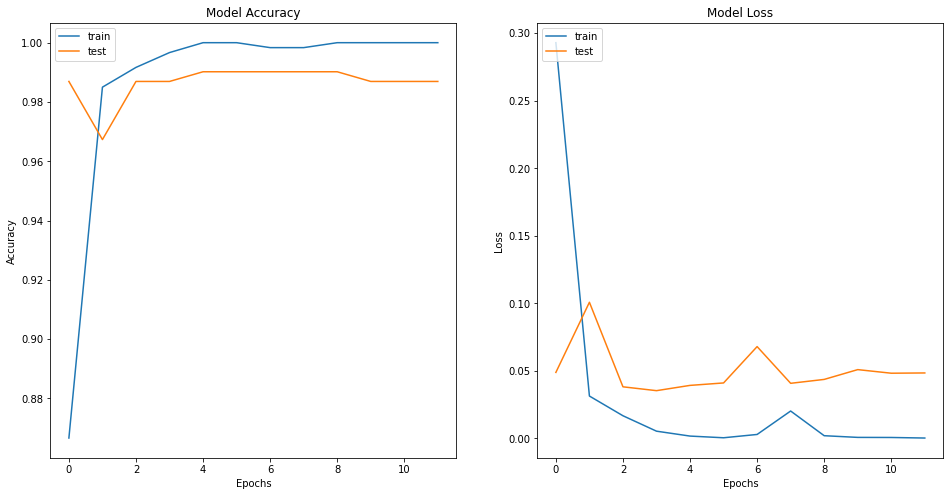

In [17]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize = (16, 8))


ax0.plot(history.history['accuracy'])
ax0.plot(history.history['val_accuracy'])
ax0.set_title('Model Accuracy')
ax0.set_xlabel('Epochs')
ax0.set_ylabel('Accuracy')
ax0.legend(['train', 'test'], loc='upper left')



ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.set_title('Model Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend(['train', 'test'], loc='upper left')

plt.show()

In [18]:
model_path = '/content/drive/MyDrive/ML_DL_practice/Face_Mask_Detection/model'

model.save(model_path+'/face_mask_model.h5')